# Super-resolución 4x:
## 2.- Modelado y Entranamiento:

Ejercicio de curso para la asignatura de Computación Inteligente perteneciente al Máster Universitario en Sistemas Inteligentes y Aplicaciones Numéricas para la Ingeniería (MUSIANI) en el curso 2020/21, realizado por Juan Sebastián Ramírez Artiles.

El ejercicio consiste en implementar el método de superresolución en imágenes descrito en el paper *Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network*. Concretamente, en este notebook se ha implementado un escalado de cuatro aumententos. El dataset usado fue el [DIV2X](https://data.vision.ee.ethz.ch/cvl/DIV2K/) de libre descarga. Las imgágenes usadas son las del track1 con un tamaño para las imágenes de alta resolución recortadas a 2040x1304.


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import torch.optim as optim

Las imágenes se cargan de cuatro directorios, cada directorio debe contener un subdirectorio de etiqueta donde se situarán las imágenes, en este caso sólo habrá un subdirectorio, por lo tanto una etiqueta cada uno. Las etiquetas de los dataset se ignorarán ya que no se van a usar. Las imágenes reales se situan en train_y_hr y valid_y_hr y tienen un tamaño de 2040x1304. Las imágenes reducidas tienen un tamaño cuatro veces menor. Para el acondicionamiento de las imágenes se usó el notebook [Super_Resolution_CI_Preprocessed](Super_Resolution_CI_Preprocessed.ipynb).

El programa se ejecutó en una máquina con un procesador Intel Core i7-7700HQ a 2.80GHz con una tarjeta de vídeo NVIDIA GeForce GTX 1050 de 4GB de memoria dedicada y con 32 GB de memoria RAM.

![](Super_Resolution_CI_3.1.JPG)

In [2]:
workers = 8
ngpu = 1
beta1 = 0.5
lr = 0.2
bs = 16
epochs = 20

path_train_x = "images/train/train_x"
path_train_y = "images/train/train_y_hr"

path_valid_x = "images/valid/valid_x"
path_valid_y = "images/valid/valid_y_hr"

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

imgs_train_x = datasets.ImageFolder(path_train_x, transform = transform)
imgs_train_y = datasets.ImageFolder(path_train_y, transform = transform)

imgs_valid_x = datasets.ImageFolder(path_valid_x, transform = transform)
imgs_valid_y = datasets.ImageFolder(path_valid_y, transform = transform)

El dataset se dividió en 611 imágenes para entrenamiento y 75 imágenes para validación.

In [4]:
print(len(imgs_train_x))
print(len(imgs_train_y))
#imgs_train_x.classes
#train_ds = TensorDataset(imgs_train_x, imgs_train_y)

611
611


In [5]:
imgs_train_x_dl = DataLoader(imgs_train_x, batch_size = bs, num_workers = workers)
imgs_train_y_dl = DataLoader(imgs_train_y, batch_size = bs, num_workers = workers)

imgs_valid_x_dl = DataLoader(imgs_valid_x, batch_size = bs, num_workers = workers)
imgs_valid_y_dl = DataLoader(imgs_valid_y, batch_size = bs, num_workers = workers)

In [6]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

El modelo hace uso de la capa PixelShuffle que se encarga de realizar el escalado a nivel subpíxel tomando como entrada un tensor de tamaño [$Batch, Channels*R^2, H, W$] y reordenándolo como [$Batch, Channels, H*R, W*R$]

Se probaron una variedad de modelos diferentes. Se usaron kernels de 3x3, de 5x5 y de 7x7, siendo estos últimos los que mejor resultados dieron. También se probaron diferentes configuraciones de red, añadiendo capas convolutivas y modificando las funciones de activación. Esta configuración resultó la más adecuada.

En el proceso de entrenamiento se usaron gran variedad de combinaciones de tamaños de batches y de cantidad de épocas. Se empezó con tamaños de batch de 8 y se fue subiendo hasta 16, más de esta cantidad desborda la memoras de la GPU. En cuanto al número de épocas, se empezó con 20 iteraciones y se fue subiendo hasta la cantidad de 80. No obstante, al variar el learning rate se aceleró la convergencia, con lo que volví a la veinte iteraciones.

In [7]:
class SuperResolution(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv = nn.Conv2d(3, 12, kernel_size = 7, padding = 3)
        self.upsample = nn.PixelShuffle(upscale_factor = 2)

    def forward(self, xb):
        
        xb = torch.tanh(self.conv(xb))
        xb = self.upsample(xb)
        xb = torch.sigmoid(self.conv(xb))
        
        return self.upsample(xb)

In [8]:
def preprocess(x, y):
    return x.to(device), y.to(device)

In [9]:
def get_model():
    model = SuperResolution().to(device)
    return model, optim.SGD(model.parameters(), lr=lr, momentum=0.9)

loss_func = nn.MSELoss(reduction='mean')

In [10]:
class WrappedDataLoader:
    def __init__(self, dl_x, dl_y, func):
        assert len(dl_x) == len(dl_y)
        self.dl_x = dl_x
        self.dl_y = dl_y
        self.func = func
    
    def __len__(self):
        return len(self.dl_x)

    def __iter__(self):
        batches_x = iter(self.dl_x)
        batches_y = iter(self.dl_y)
        
        for b_x, _ in batches_x:
            b_y, _ = batches_y.next()
            yield (self.func(b_x, b_y))
        

In [11]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    return loss.item(), len(xb)

In [12]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, val_losses):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        val_losses.append(val_loss)
        
        print(epoch, val_loss)

In [13]:
train_dl = WrappedDataLoader(imgs_train_x_dl, imgs_train_y_dl, preprocess)
valid_dl = WrappedDataLoader(imgs_valid_x_dl, imgs_valid_y_dl, preprocess)

val_losses = []

model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl, val_losses)

0 0.28736064354578655
1 0.2473911871512731
2 0.2408711491028468
3 0.2380747373898824
4 0.23652935087680815
5 0.23554478367169698
6 0.23478499591350555
7 0.23418607393900553
8 0.2337447412808736
9 0.23341579814751942
10 0.23313918908437092
11 0.23288639684518178
12 0.23265165348847708
13 0.23243224104245505
14 0.2322255758444468
15 0.23202941715717315
16 0.23184201101462046
17 0.23166203280289968
18 0.2314884678522746
19 0.231320605079333


Se puede observar en el gráfico que la red aprende bien.

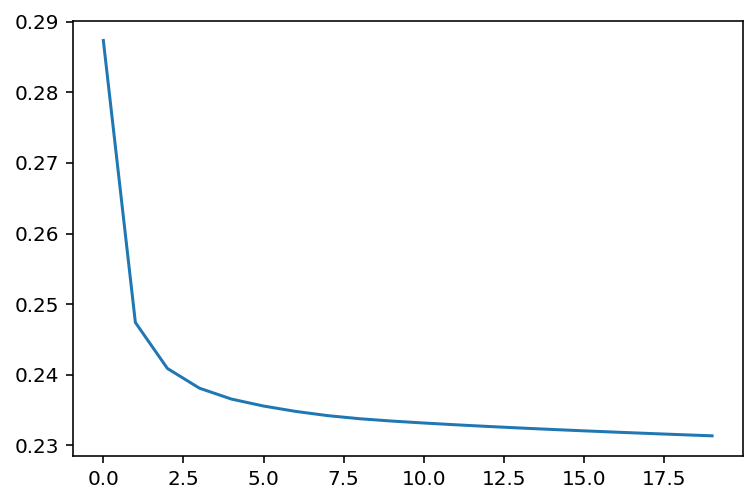

In [14]:
plt.plot(val_losses)
plt.show()

Para finalizar, salvo el modelo para poder usarlo en el notebook [SR_restore_model.ipynb](SR_restore_model.ipynb) que se encargará de escalar las 75 imágenes de validación.

In [15]:
torch.save(model, "SR_model_3.3.ml")

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>